In [259]:
import cvxopt as cvx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.spatial.distance as dt
from sklearn.metrics import accuracy_score

In [260]:
# read data into memory
X = np.genfromtxt("hw06_images.csv", delimiter = ",")
y = np.genfromtxt("hw06_labels.csv").astype(int)

In [261]:
X_train = X[:1000,:]
X_test = X[1000:,:]
y_train = y[:1000]
y_test = y[1000:]

# get number of samples and number of features
N_train = len(y_train)
N_test = len(y_test)
D = X.shape[1]

In [262]:
# define Gaussian kernel function
def gaussian_kernel(X1, X2, s):
    D = dt.cdist(X1, X2)
    K = np.exp(-D**2 / (2 * s**2))
    return(K)

In [263]:
# set learning parameters
C = 10
epsilon = 1e-3
s = 10

In [264]:
def kernal_machine(K, y, C, N, D, epsilon):
    # calculate Gaussian kernel
    yyK = np.matmul(y[:,None], y[None,:]) * K


    P = cvx.matrix(yyK)
    q = cvx.matrix(-np.ones((N, 1)))
    G = cvx.matrix(np.vstack((-np.eye(N), np.eye(N))))
    h = cvx.matrix(np.vstack((np.zeros((N, 1)), C * np.ones((N, 1)))))
    A = cvx.matrix(1.0 * y[None,:])
    b = cvx.matrix(0.0)

    # use cvxopt library to solve QP problems
    result = cvx.solvers.qp(P, q, G, h, A, b)
    alpha = np.reshape(result["x"], N)
    alpha[alpha < C * epsilon] = 0
    alpha[alpha > C * (1 - epsilon)] = C

    # find bias parameter
    support_indices, = np.where(alpha != 0)
    active_indices, = np.where(np.logical_and(alpha != 0, alpha < C))
    w0 = np.mean(y[active_indices] * (1 - np.matmul(yyK[np.ix_(active_indices, support_indices)], alpha[support_indices])))
    
    return w0, alpha

In [265]:
K_test = gaussian_kernel(X_test, X_train, s)
gscore_test = np.array([])
K_train = gaussian_kernel(X_train, X_train, s)
gscore_train = np.array([])
for i in range(np.max(y)):
    y_train_temp = y_train.copy()
    y_train_temp[y_train_temp[:] != i+1] = -1
    y_train_temp[y_train_temp[:] == i+1] = 1
    w0, alpha = kernal_machine(K_train, y_train_temp, C, N_train, D, epsilon)
    # calculate predictions on training samples
    f_predicted_train = np.matmul(K_train, y_train_temp[:,None] * alpha[:,None]) + w0
    f_predicted_test = np.matmul(K_test, y_train_temp[:,None] * alpha[:,None]) + w0
    gscore_train = np.append(gscore_train, f_predicted_train)
    gscore_test = np.append(gscore_test, f_predicted_test)

     pcost       dcost       gap    pres   dres
 0:  2.9600e+01 -4.2260e+04  8e+04  4e-01  4e-14
 1:  1.2992e+01 -7.4611e+03  8e+03  2e-02  3e-14
 2: -6.2643e+02 -2.9089e+03  2e+03  4e-03  3e-14
 3: -8.9105e+02 -1.7204e+03  8e+02  1e-03  3e-14
 4: -1.0255e+03 -1.3482e+03  3e+02  2e-04  3e-14
 5: -1.0893e+03 -1.1778e+03  9e+01  2e-05  4e-14
 6: -1.1096e+03 -1.1353e+03  3e+01  3e-07  4e-14
 7: -1.1169e+03 -1.1209e+03  4e+00  3e-14  4e-14
 8: -1.1184e+03 -1.1185e+03  1e-01  7e-14  4e-14
 9: -1.1185e+03 -1.1185e+03  4e-03  9e-16  4e-14
10: -1.1185e+03 -1.1185e+03  7e-05  5e-14  4e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.9161e+02 -4.0951e+04  8e+04  4e-01  3e-14
 1:  1.7375e+02 -7.6611e+03  9e+03  2e-02  2e-14
 2: -4.0615e+02 -2.9616e+03  3e+03  6e-03  2e-14
 3: -6.2557e+02 -1.7531e+03  1e+03  2e-03  3e-14
 4: -7.5417e+02 -1.1618e+03  4e+02  4e-04  3e-14
 5: -8.2696e+02 -9.7495e+02  1e+02  3e-14  3e-14
 6: -8.5262e+02 -8.9665e+02  4e+01  3e-14  3e-1

In [266]:
y_train_predicted = np.argmax(gscore_train.reshape(5,1000), axis = 0) + 1
y_test_predicted = np.argmax(gscore_test.reshape(5,4000), axis = 0) + 1

In [267]:
confusion_matrix = pd.crosstab(np.reshape(y_train_predicted, N_train), y_train, rownames = ['y_predicted'], colnames = ['y_train'])
print(confusion_matrix)

y_train        1    2    3    4    5
y_predicted                         
1            207    1    0    9    0
2              2  199    1    1    0
3              0    1  204    6    0
4              0    1    4  185    1
5              0    0    0    0  178


In [268]:
confusion_matrix = pd.crosstab(np.reshape(y_test_predicted, N_test), y_test, rownames = ['y_predicted'], colnames = ['y_test'])
print(confusion_matrix)

y_test         1    2    3    4    5
y_predicted                         
1            641   23    3  137    9
2             43  714   27   40    4
3              4   39  666   90   10
4            100   32   69  541   16
5             12    2    6   15  757


In [269]:
regularization_parameters = np.array([0.1, 1, 10, 100, 1000])

In [273]:
accuracy_train_storer = np.array([])
accuracy_test_storer = np.array([])

for i in regularization_parameters:
    gscore_train = np.array([])
    gscore_test = np.array([])
    for j in range(np.max(y)):
        y_train_temp = y_train.copy()
        y_train_temp[y_train_temp[:] != j+1] = -1
        y_train_temp[y_train_temp[:] == j+1] = 1
        w0, alpha = kernal_machine(K_train, y_train_temp, i , N_train, D, epsilon)
        f_predicted_train = np.matmul(K_train, y_train_temp[:,None] * alpha[:,None]) + w0
        f_predicted_test = np.matmul(K_test, y_train_temp[:,None] * alpha[:,None]) + w0
        gscore_train = np.append(gscore_train, f_predicted_train)
        gscore_test = np.append(gscore_test, f_predicted_test)
        
    y_train_predicted = np.argmax(gscore_train.reshape(5,1000), axis = 0) + 1
    y_test_predicted = np.argmax(gscore_test.reshape(5,4000), axis = 0) + 1    
    accuracy_train_storer = np.append(accuracy_train_storer, accuracy_score(y_train, y_train_predicted))
    accuracy_test_storer = np.append(accuracy_test_storer, accuracy_score(y_test, y_test_predicted))

     pcost       dcost       gap    pres   dres
 0: -1.3936e+02 -2.2047e+02  7e+03  3e+01  3e-15
 1: -3.4801e+01 -2.0264e+02  4e+02  9e-01  3e-15
 2: -2.8151e+01 -7.9601e+01  5e+01  2e-15  1e-15
 3: -3.1266e+01 -4.3423e+01  1e+01  1e-15  8e-16
 4: -3.2572e+01 -3.9120e+01  7e+00  6e-16  6e-16
 5: -3.3423e+01 -3.6637e+01  3e+00  8e-16  6e-16
 6: -3.3666e+01 -3.6029e+01  2e+00  8e-16  6e-16
 7: -3.4121e+01 -3.4971e+01  9e-01  1e-15  7e-16
 8: -3.4319e+01 -3.4585e+01  3e-01  5e-16  7e-16
 9: -3.4415e+01 -3.4445e+01  3e-02  9e-16  8e-16
10: -3.4429e+01 -3.4430e+01  1e-03  4e-16  9e-16
11: -3.4429e+01 -3.4429e+01  5e-05  6e-16  8e-16
12: -3.4429e+01 -3.4429e+01  1e-06  2e-16  8e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.1812e+02 -2.1835e+02  7e+03  3e+01  3e-15
 1: -3.1287e+01 -2.0015e+02  5e+02  1e+00  3e-15
 2: -2.4529e+01 -8.1514e+01  6e+01  7e-16  1e-15
 3: -2.7550e+01 -4.0807e+01  1e+01  4e-16  8e-16
 4: -2.8779e+01 -3.6453e+01  8e+00  2e-16  6e-1

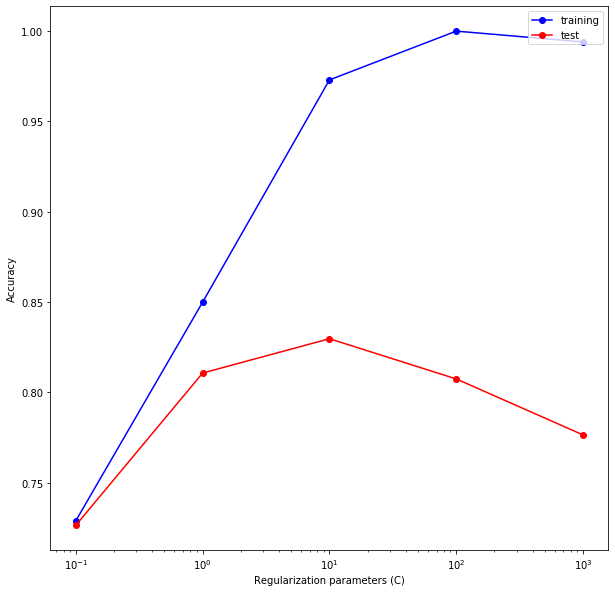

In [299]:
plt.figure(figsize = (10, 10))
plt.plot(regularization_parameters, accuracy_train_storer, "bo-")
plt.plot(regularization_parameters, accuracy_test_storer, "ro-")
plt.xscale("log")
plt.xlabel("Regularization parameters (C)")
plt.ylabel("Accuracy")
plt.legend(["training", "test"], loc ="upper right")
